# Paper figures

## Import libraries

In [1]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysankey import sankey  # https://github.com/Pierre-Sassoulas/pySankey
from upsetplot import UpSet  # https://upsetplot.readthedocs.io/en/stable/index.html
from upsetplot import plot as UPplot
import yaml

pd.set_option("display.max_colwidth", None)

## Load data

All data files should be located in `../data/`

In [2]:
df = pd.DataFrame()
for repository in ["zenodo", "figshare", "osf"]:
    datasets = pd.read_csv(
        f"../data/{repository}_datasets.tsv",
        sep="\t",
        dtype={"dataset_id": str}
    )
    print(f"{repository}: found {datasets.shape[0]} datasets.")
    files = pd.read_csv(
        f"../data/{repository}_files.tsv",
        sep="\t",
        dtype={"dataset_id": str, "file_type": str,
               "file_md5": str, "file_url": str}
    )
    print(f"{repository}: found {files.shape[0]} files.")
    tab = pd.merge(files, datasets, how="left", on=["dataset_id", "dataset_origin"], validate="many_to_one")
    print(f"{repository}: merged dataframe has {tab.shape[0]} entries.")
    df = pd.concat([df, tab], ignore_index=True)

print(f"\nDimensions of the final dataframe: {df.shape[0]} lines (files) x {df.shape[1]} columns")

zenodo: found 981 datasets.
zenodo: found 153608 files.
zenodo: merged dataframe has 153608 entries.
figshare: found 901 datasets.
figshare: found 78954 files.
figshare: merged dataframe has 78954 entries.
osf: found 66 datasets.
osf: found 6133 files.
osf: merged dataframe has 6133 entries.

Dimensions of the final dataframe: 238695 lines (files) x 18 columns


### Assign year

In [3]:
df["year"] = df["date_creation"].apply(lambda x: int(x[:4]))

### Assign MD engine

In [4]:
file_types_list = []
with open("../params/file_types.yml", "r") as param_file:
    data_loaded = yaml.safe_load(param_file)
    file_types_list = data_loaded["file_types"]

    ext_gromacs = []
ext_namd = []
ext_amber = []
ext_charmm = []
ext_desmond = []

list_coordinate = []
list_trajectory = []
list_topology = []

for type_dict in file_types_list:
    # assign MD engine
    if type_dict["engine"] == "gromacs":
        ext_gromacs.append(type_dict["type"])
    elif type_dict["engine"] == "namd":
        ext_namd.append(type_dict["type"])
    elif type_dict["engine"] == "amber":
        ext_amber.append(type_dict["type"])
    elif type_dict["engine"] == "charmm":
        ext_charmm.append(type_dict["type"])
    elif type_dict["engine"] == "desmond":
        ext_desmond.append(type_dict["type"])
    # assign file category
    if type_dict["category"] == "coordinate":
        list_coordinate.append(type_dict["type"])
    elif type_dict["category"] == "topology":
        list_topology.append(type_dict["type"])
    elif type_dict["category"] == "trajectory":
        list_trajectory.append(type_dict["type"])

ext_all = ext_gromacs + ext_namd + ext_amber + ext_charmm
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

def assign_md_engine(file_type):
    """Assign MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "GROMACS"
    elif file_type in (ext_namd + ext_charmm):
        return "NAMD/CHARMM"
    elif file_type in ext_amber:
        return "AMBER"
    elif file_type in ext_desmond:
        return "DESMOND"
    else:
        return "None"

df["MD_engine"] = df["file_type"].apply(assign_md_engine)

### Number of datasets and files per MD engine

In [5]:
(df.
 groupby("MD_engine")
 .agg({"dataset_id": ["nunique", "count"]})
 .rename(columns={
     "dataset_id": "",
     "nunique": "datasets",
     "count": "files"
 })
)

datasets   files
MD_engine                   
AMBER            224    9803
DESMOND           48    1855
GROMACS         1228   83552
NAMD/CHARMM      660   12294
None            1137  131191

### Assign category

In [6]:
def assign_file_category(file_type):
    """Assign file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

df["category"] = df["file_type"].apply(assign_file_category)
df["category"].value_counts()

none          167179
trajectory     35321
topology       29476
coordinate      6719
Name: category, dtype: int64

## Figure 1

Evolution of number of “molecular dynamics” papers in PubMed vs time

See notebook `search_MD_in_pubmed.ipynb`.

## Figure 2

### 2.B. Evolution of the number MD files deposited in data repositories

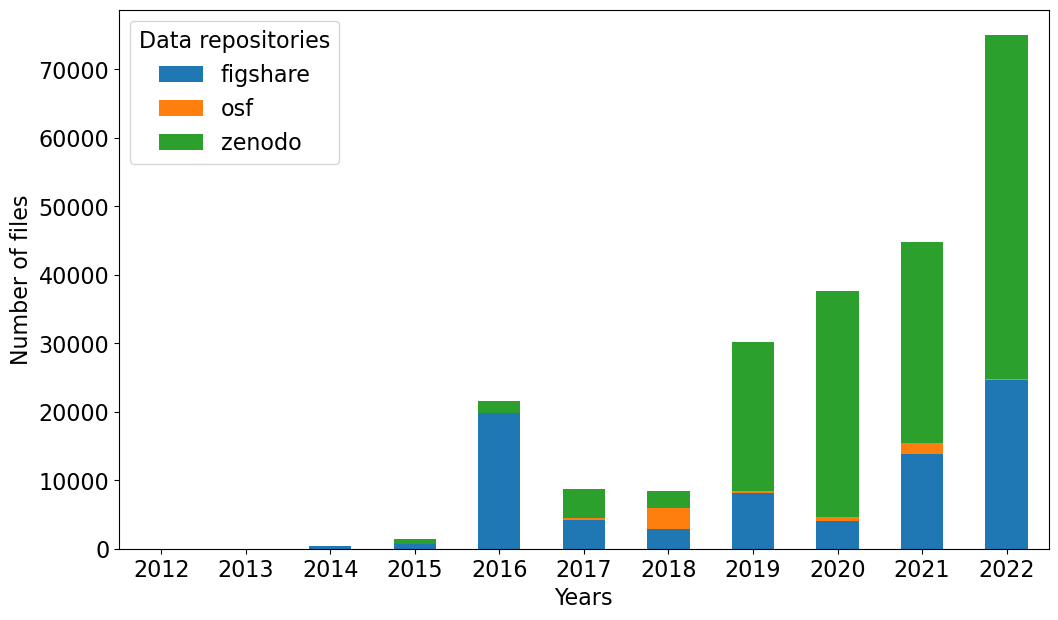

In [7]:
plt.rcParams.update({'font.size': 16})
(df
 .query("year != 2023")
 .query("year >= 2012")
 .groupby(["year", "dataset_origin"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="Data repositories")
filename = "fig/number_of_files_per_years_per_data_repositories"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

### 2.B. MD engines distribution

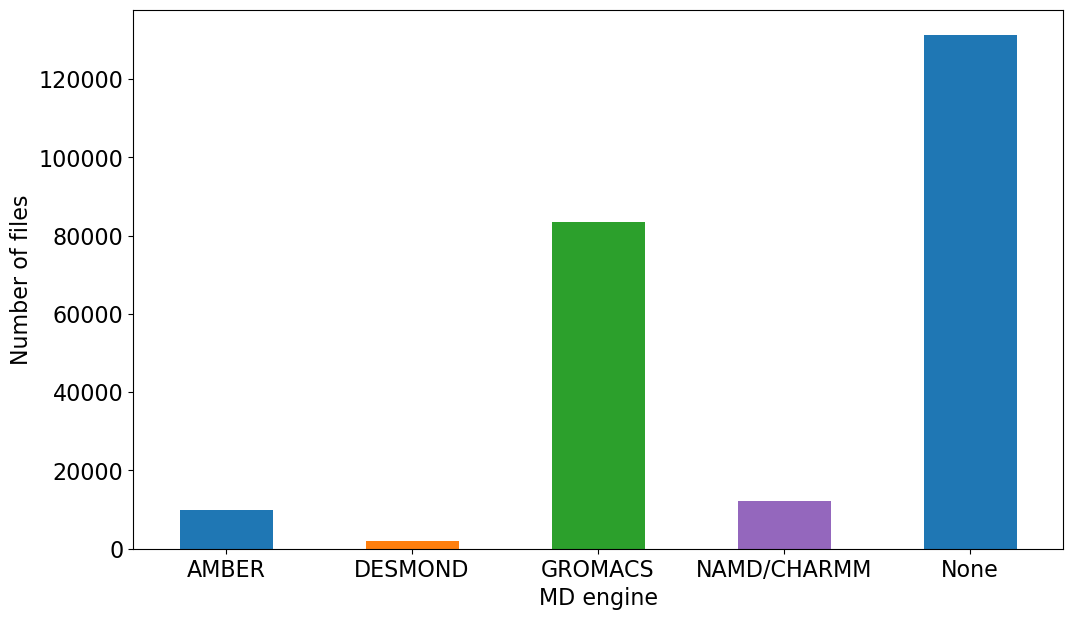

In [8]:
plt.rcParams.update({'font.size': 16})
(df
 .loc[:, "MD_engine"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple"], figsize=(12,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
filename = "fig/number_of_files_per_MD_engine"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

### 2.C. Type of files not associated to any MD engine

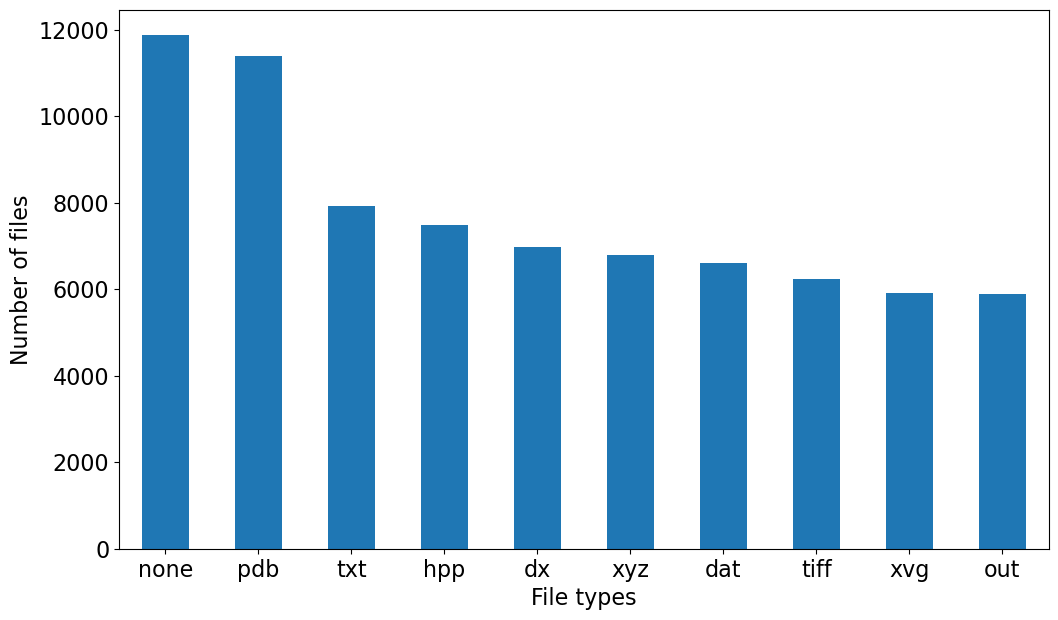

In [9]:
plt.rcParams.update({'font.size': 16})
(df
 .query("MD_engine == 'None'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="tab:blue", figsize=(12,7))
)
plt.xlabel("File types")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
filename = "fig/number_of_files_per_filetype_no_MD_engine"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

Most files with no file type are simulation snapshots, log or README files.

## Figure 3

### 3.A. Gromacs file types by categories

10 most frequent Gromacs file types

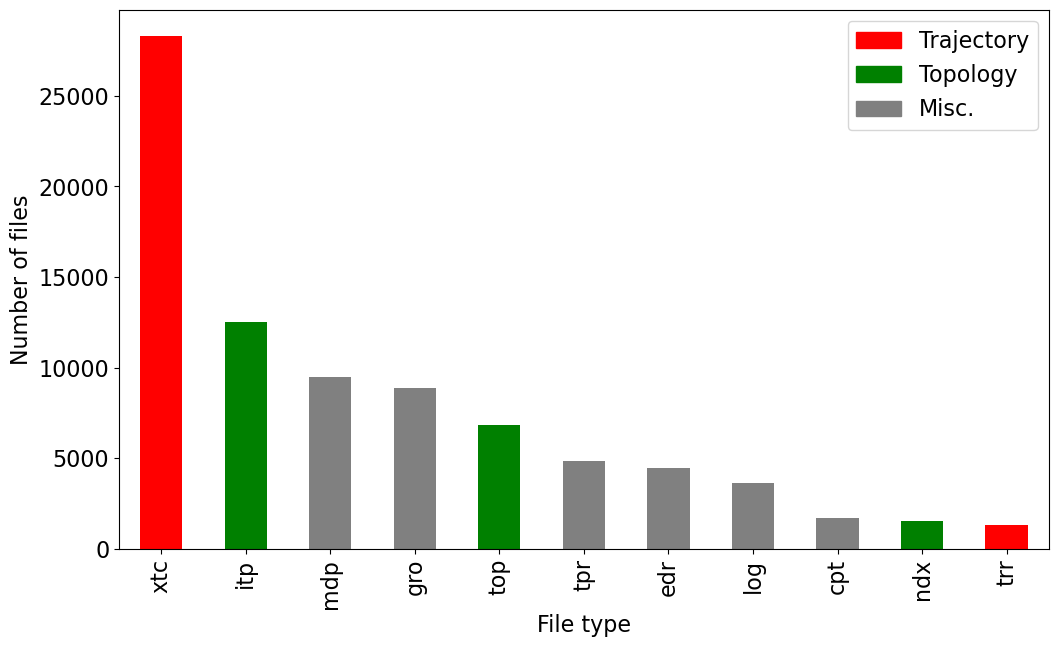

In [10]:
colors={
    "trajectory":"red",
    "topology":"green",
    "none":"grey"
}
gromacs_file_types = (df
 .query("MD_engine == 'GROMACS'")
 .groupby("file_type").agg({"category": "first", "file_name": "count"})
 .sort_values(by="file_name", ascending=False)
)
plt.rcParams.update({'font.size': 16})
gromacs_file_types["color"] = gromacs_file_types["category"].map(colors)
gromacs_file_types.plot(kind="bar", y="file_name", figsize=(12,7), color=gromacs_file_types["color"])
plt.xlabel("File type")
plt.ylabel("Number of files")
# Custom legend.
traj_patch = mpatches.Patch(color="red", label="Trajectory")
topol_patch = mpatches.Patch(color="green", label="Topology")
misc_patch = mpatches.Patch(color="grey", label="Misc.")
plt.legend(handles=[traj_patch, topol_patch, misc_patch])
filename = "fig/number_of_files_by_Gromacs_filetype"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

In [11]:
gromacs_files = df.query("MD_engine == 'GROMACS'")
print(
    f"Total of {gromacs_files.shape[0]} Gromacs files "
    f"from {gromacs_files['dataset_id'].nunique()} datasets."
)

Total of 83552 Gromacs files from 1228 datasets.


### 3.B. Cumulated distribution of gro files

In [12]:
gro_df = pd.read_csv("../data/gromacs_gro_files_info.tsv", sep="\t")
gro_df = pd.merge(
    gro_df,
    df[["dataset_origin", "dataset_id", "dataset_url"]].drop_duplicates(),
    on=["dataset_origin", "dataset_id"],
    how="left"
)
print(f"Dataset has {gro_df.shape[0]} gro files")
gro_df.head()

Dataset has 10777 gro files


,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url
0,osf,6fuqs,3468,True,False,False,False,False,Trajectories/4_su.gro,https://osf.io/6fuqs/
1,osf,6fuqs,3468,True,False,False,False,False,Trajectories/6_su.gro,https://osf.io/6fuqs/
2,osf,6fuqs,3468,True,False,False,False,False,Trajectories/3_su.gro,https://osf.io/6fuqs/
3,osf,6fuqs,3468,True,False,False,False,False,Trajectories/8_su.gro,https://osf.io/6fuqs/
4,osf,6fuqs,3468,True,False,False,False,False,Trajectories/2_su.gro,https://osf.io/6fuqs/


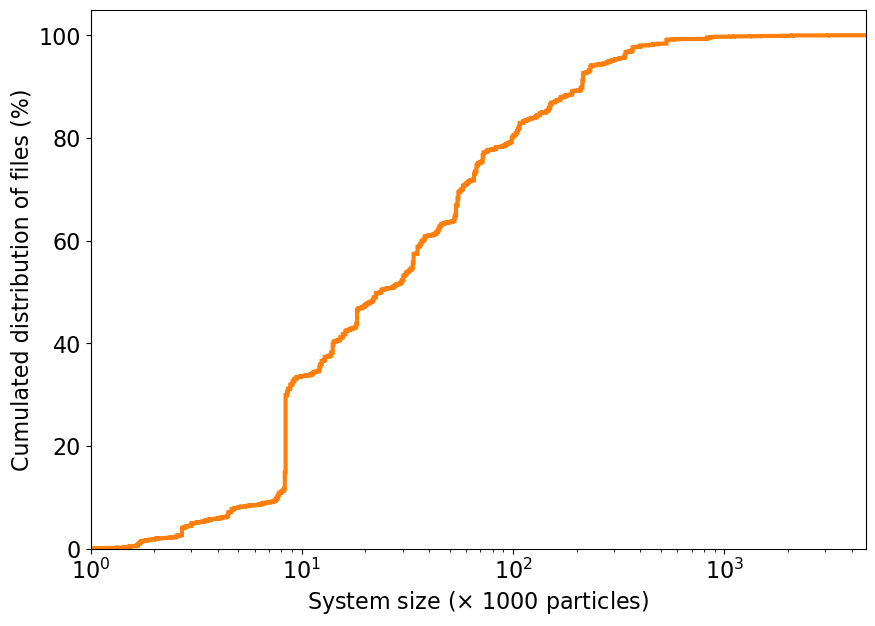

In [13]:
def plot_system_size_distribution(df):
    """Plot system size distribution"""
    # Convert system size to k-particules (1000) 
    df["k_particles"] = gro_df["atom_number"] / 1000

    logbins = np.geomspace(df["k_particles"].min()+1, df["k_particles"].max(), 1_000)

    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    values, bins, _ = ax.hist(
        df["k_particles"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True, density=True
    )
    ax.set_xlabel(r"System size ($\times$ 1000 particles)")
    ax.set_ylabel("Cumulated distribution of files (%)")
    ax.set_yticks(np.arange(0, 1.1, 0.2), [f"{value:.0f}" for value in np.arange(0, 1.1, 0.2)*100])
    ax.set_xscale("log")
    ax.set_xlim(1, df["k_particles"].max() - df["k_particles"].max()*0.1)
    filename = "fig/gromacs_gro_system_size_cumulated_distribution"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_system_size_distribution(gro_df)

Smallest systems:

In [14]:
(gro_df
 .query("atom_number < 10")
 .sort_values(by="atom_number", ascending=True)
 .head(10)
)

,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url,k_particles
10269,figshare,8846045,2,False,False,False,False,False,Tutorial/gro/cell.gro,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045,0.002
9829,figshare,5190502,3,False,False,False,False,False,H2O_v2.gro,https://tandf.figshare.com/articles/dataset/Organic_and_Third_Phase_in_HNO_sub_3_sub_TBP_i_n_i_-Dodecane_System_No_Reverse_Micelles/5190502,0.003
10683,figshare,12517490,3,False,False,False,False,False,topolpgy_backmapping_files/topologies/Benzene/benzene_cg.gro,https://acs.figshare.com/articles/dataset/Capturing_Protein_Ligand_Recognition_Pathways_in_Coarse-Grained_Simulation/12517490,0.003
10668,figshare,19534516,3,False,False,False,False,False,setup_files/2_packmol/CO2.gro,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.003
10666,figshare,19534516,3,False,False,False,True,False,setup_files/2_packmol/H2O.gro,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.003
9879,figshare,11702442,4,False,False,False,False,False,ct9b01139_si_001/Topology_Files/AMMONIA/AMMONIA_GMX.gro,https://acs.figshare.com/articles/dataset/Alchemical_Hydration_Free-Energy_Calculations_Using_Molecular_Dynamics_with_Explicit_Polarization_and_Induced_Polarity_Decoupling_An_On_the_Fly_Polarization_Approach/11702442,0.004
9831,figshare,5190502,5,False,False,False,False,False,HNO3_v2.gro,https://tandf.figshare.com/articles/dataset/Organic_and_Third_Phase_in_HNO_sub_3_sub_TBP_i_n_i_-Dodecane_System_No_Reverse_Micelles/5190502,0.005
10667,figshare,19534516,5,False,False,False,False,False,setup_files/2_packmol/CH4.gro,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.005
10270,figshare,8846045,6,False,False,False,False,False,Tutorial/gro/AL1.gro,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045,0.006
10695,figshare,14959779,6,False,False,False,False,False,md_files/small_molecules/ethene/opls.gro,https://acs.figshare.com/articles/dataset/Q_Force_Quantum_Mechanically_Augmented_Molecular_Force_Fields/14959779,0.006


Largest systems:

In [15]:
(gro_df
 .query("atom_number > 2_000_000")
 .sort_values(by="atom_number", ascending=False)
 .head(10)
)

,dataset_origin,dataset_id,atom_number,has_protein,has_nucleic,has_lipid,has_water_ion,has_glucid,filename,dataset_url,k_particles
9572,figshare,1238172,5184000,False,False,False,True,False,water01.gro,https://figshare.com/articles/dataset/water01_gro_Water_coordinate_file_for_cryo_EM_image_simulation/1238172,5184.000
3353,zenodo,3634884,3522816,True,False,True,True,False,PM_large_lastframe.noW.gro,https://zenodo.org/record/3634884,3522.816
7378,zenodo,6797842,3113594,True,False,True,True,False,simulations/protein_simulations/prepore/33mer_largemembrane/prepore_33mer_largemembrane_2200ns.gro,https://zenodo.org/record/6797842,3113.594
7379,zenodo,6797842,3113594,True,False,True,True,False,simulations/protein_simulations/prepore/33mer_largemembrane/prepore_33mer_largemembrane_equilibrated.gro,https://zenodo.org/record/6797842,3113.594
10157,figshare,14919822,2621751,True,False,False,True,False,Data_share/SMD_data/SMD_structure_data/OUTPUT/Spike_CR3022-4A8/Spike-4A8_1_pull_005.gro,https://acs.figshare.com/articles/dataset/Electrostatic_Interactions_Explain_the_Higher_Binding_Affinity_of_the_CR3022_Antibody_for_SARS-CoV_2_than_the_4A8_Antibody/14919822,2621.751
7364,zenodo,6797842,2125422,True,False,True,True,False,simulations/protein_simulations/pore/27mer/27mer_equilibrated.gro,https://zenodo.org/record/6797842,2125.422
7365,zenodo,6797842,2125422,True,False,True,True,False,simulations/protein_simulations/pore/27mer/27mer_4100ns.gro,https://zenodo.org/record/6797842,2125.422
7353,zenodo,6797842,2119785,True,False,True,True,False,simulations/protein_simulations/pore/33mer/33mer_equilibrated.gro,https://zenodo.org/record/6797842,2119.785
7354,zenodo,6797842,2119785,True,False,True,True,False,simulations/protein_simulations/pore/33mer/33mer_5000ns.gro,https://zenodo.org/record/6797842,2119.785
7355,zenodo,6797842,2119785,True,False,True,True,False,simulations/protein_simulations/pore/33mer/33mer_70C_1500ns.gro,https://zenodo.org/record/6797842,2119.785


### 3.C. System composition

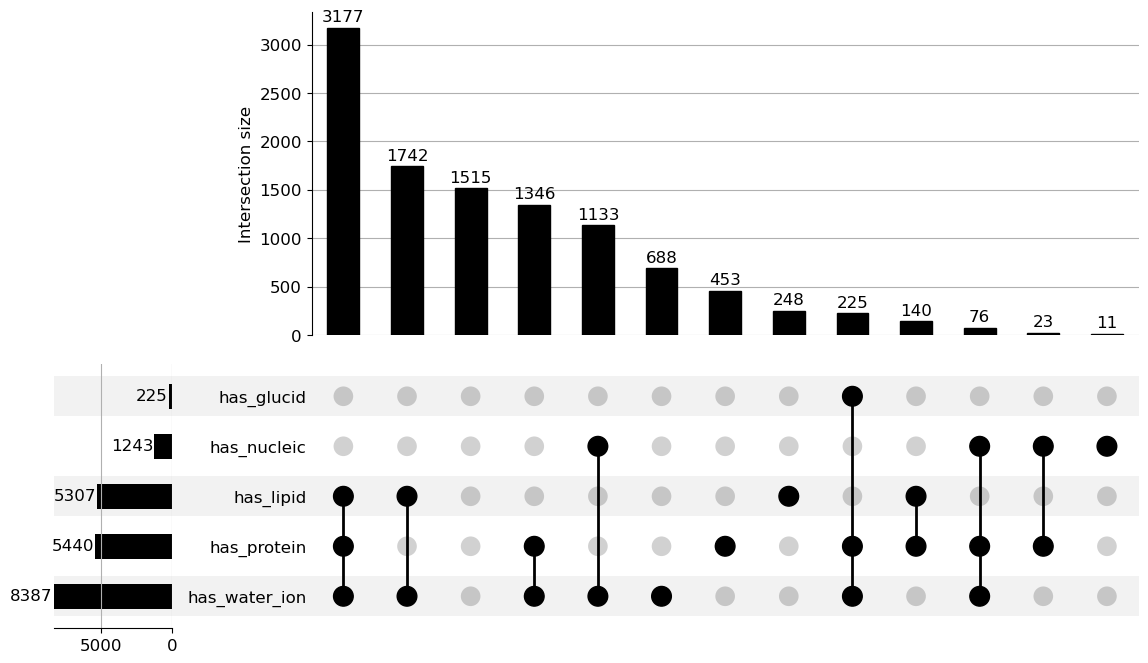

In [16]:
# Create pivot dataframe
df_upset = pd.pivot_table(
    gro_df, 
    index=["has_protein", "has_lipid", "has_nucleic", "has_water_ion", "has_glucid"], 
    values=["filename"], 
    aggfunc=len
)
# Convert pivot dataframe to Pandas Series with multi-index
sr_upset = pd.Series(index=df_upset.index, data=df_upset.values.flatten(), name="value")
plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 8))
UPplot(sr_upset, fig=fig, show_counts=True, element_size=None, sort_by="cardinality")
filename = "fig/gromacs_system_composition"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

## Figure 4

### 4.A. Simulation temperature

In [17]:
mdp_df = pd.read_csv("../data/gromacs_mdp_files_info.tsv", sep="\t")
mdp_df = pd.merge(
    mdp_df,
    df[["dataset_origin", "dataset_id", "dataset_url"]].drop_duplicates(),
    on=["dataset_origin", "dataset_id"],
    how="left"
)
print(f"Dataset has {mdp_df.shape[0]} gro files")
mdp_df.head()

Dataset has 11295 gro files


,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
0,osf,2ah8r,0.001,2500000.0,303.15,NaN,berendsen,step6.2_equilibration.mdp,https://osf.io/2ah8r/
1,osf,2ah8r,0.002,5000000.0,303.15,berendsen,berendsen,step6.4_equilibration.mdp,https://osf.io/2ah8r/
2,osf,2ah8r,0.001,2500000.0,303.15,berendsen,berendsen,step6.3_equilibration.mdp,https://osf.io/2ah8r/
3,osf,2ah8r,0.002,5000000.0,303.15,berendsen,berendsen,step6.6_equilibration.mdp,https://osf.io/2ah8r/
4,osf,2ah8r,0.002,100000000.0,303.15,Parrinello-Rahman,Nose-Hoover,step7_production.mdp,https://osf.io/2ah8r/


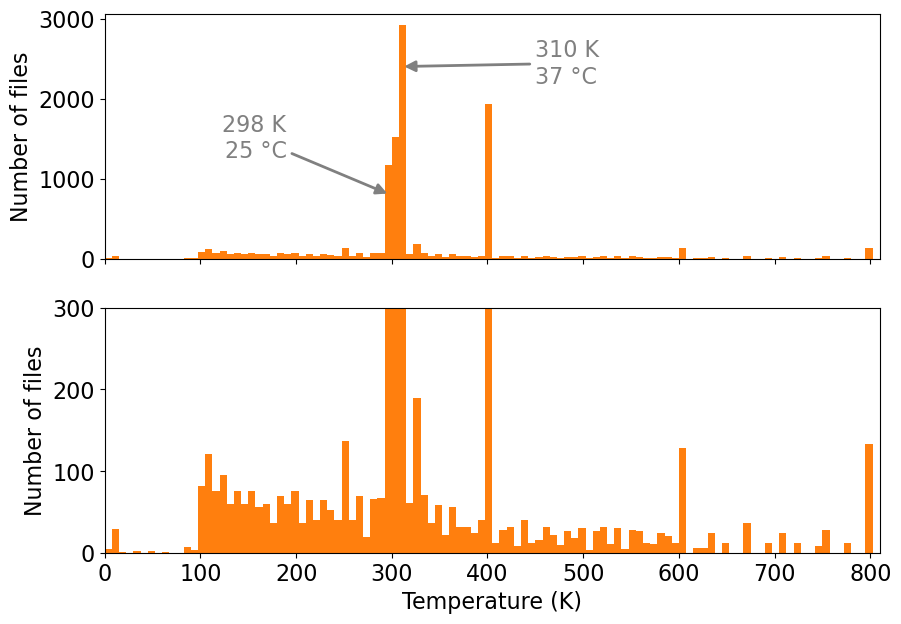

In [18]:
def plot_temperature_histogram(df):
    """Create plot for temperature distribution"""
    bins=200
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(2, sharex=True, figsize=(10,7))
    ax[0].hist(df["temperature"], bins=bins, color="tab:orange")
    ax[0].set_ylabel("Number of files")
    ax[0].set_xlim(0, 810)
    ax[0].annotate("310 K\n37 °C", xy=(310, 2400), xytext=(450, 2750), color="gray",
                 arrowprops={"arrowstyle":"-|>", "lw":2, "color":"gray", "connectionstyle":"arc3"}, 
                 horizontalalignment="left", verticalalignment="top")
    ax[0].annotate("298 K\n25 °C", xy=(298, 800), xytext=(190, 1200), color="gray",
                 arrowprops={"arrowstyle":"-|>", "lw":2, "color":"gray"}, 
                 horizontalalignment="right", verticalalignment="bottom")

    ax[1].hist(df["temperature"], bins=bins, color="tab:orange")
    ax[1].set_ylabel("Number of files")
    ax[1].set_ylim(0, 300)
    ax[1].set_xlabel("Temperature (K)")
    filename = "fig/gromacs_temperature_histogram"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_temperature_histogram(mdp_df)

### Lowest temperatures

In [19]:
mdp_df.query("temperature < 20")

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
5003,figshare,3408676,0.0010,1000000.0,15.0,NaN,NaN,Validation/WaterHexamer/gmx/run.mdp,https://acs.figshare.com/articles/dataset/TopoGromacs_Automated_Topology_Conversion_from_CHARMM_to_GROMACS_within_VMD/3408676
5021,figshare,7370684,0.0020,5000.0,0.0,no,v-rescale,md_files/2-MD-runs/mdp/1_grompp_minimisation.mdp,https://acs.figshare.com/articles/dataset/Stereospecific_1_3_H_Transfer_of_Indenols_Proceeds_via_Persistent_Ion-Pairs_Anchored_by_NH__Interactions/7370684
5485,figshare,10269416,0.0005,10000000.0,10.0,Parrinello-Rahman,nose-hoover,input_files/MD/production.mdp,https://acs.figshare.com/articles/dataset/Adding_Anisotropy_to_the_Standard_Quasi-Harmonic_Approximation_Still_Fails_in_Several_Ways_to_Capture_Organic_Crystal_Thermodynamics/10269416
5486,figshare,10269416,0.0005,60000000.0,3.0,Parrinello-Rahman,nose-hoover,input_files/MD/production_REMD.mdp,https://acs.figshare.com/articles/dataset/Adding_Anisotropy_to_the_Standard_Quasi-Harmonic_Approximation_Still_Fails_in_Several_Ways_to_Capture_Organic_Crystal_Thermodynamics/10269416
5786,figshare,8846045,0.0300,10000.0,0.0,berendsen,Berendsen,Tutorial/mdp/2_npt.mdp,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
5788,figshare,8846045,0.0300,1000000.0,0.0,berendsen,Berendsen,Tutorial/mdp/3_run.mdp,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
5789,figshare,8846045,0.0300,5000.0,0.0,no,Berendsen,Tutorial/mdp/2_nvt.mdp,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
7049,figshare,21644393,0.0010,0.0,10.0,no,berendsen,SI/Theophylline/GAFFTIP3P/Theophylline/Freeze_10/production.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
7050,figshare,21644393,0.0010,5000000.0,10.0,no,berendsen,SI/Theophylline/GAFFTIP3P/Theophylline/Freeze_10/equilibration.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
7199,figshare,21644393,0.0010,0.0,10.0,berendsen,berendsen,SI/Theophylline/GAFFTIP3P/formII/Freeze_10/production.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393


### Systems with temperature around 100 K

In [20]:
(mdp_df
 .query("temperature > 80")
 .query("temperature < 120")
)

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
37,osf,82n73,0.002,50000.0,100.0,no,Berendsen,"Molecular Dynamics/Standard Operating Procedure/Gromacs v2016.1/1. Topology Creation, Forcefield Formation, and Energy Minimization/2. NVT/nvt_membrane.mdp",https://osf.io/82n73/
41,osf,82n73,0.002,250000.0,100.0,no,V-rescale,"Molecular Dynamics/Standard Operating Procedure/Gromacs v2016.1/1. Topology Creation, Forcefield Formation, and Energy Minimization/2. NVT/nvt_DNA.mdp",https://osf.io/82n73/
52,osf,82n73,0.002,50000.0,100.0,no,Berendsen,"Molecular Dynamics/Standard Operating Procedure/Gromacs v5.0/1. Topology Creation, Forcefield Formation, and Energy Minimization/2. NVT/nvt_membrnae.mdp",https://osf.io/82n73/
54,osf,82n73,0.002,250000.0,100.0,no,V-rescale,"Molecular Dynamics/Standard Operating Procedure/Gromacs v5.0/1. Topology Creation, Forcefield Formation, and Energy Minimization/2. NVT/nvt_DNA.mdp",https://osf.io/82n73/
77,osf,82n73,0.002,50000.0,100.0,no,Berendsen,"Molecular Dynamics/Standard Operating Procedure/Gromacs v4.6/1. Topology Creation, Forcefield Formation, and Energy Minimization/2. NVT/nvt_membrnae.mdp",https://osf.io/82n73/
...,...,...,...,...,...,...,...,...,...
10917,figshare,21644393,0.001,1000000.0,115.0,berendsen,v-rescale,SI/Gandotinib/GAFFTIP3P/tetrahydrate/Temperatures/115/equilibration.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
10925,figshare,21644393,0.001,5000000.0,100.0,Parrinello-Rahman,v-rescale,SI/Gandotinib/GAFFTIP3P/tetrahydrate/Temperatures/100/production.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
10926,figshare,21644393,0.001,1000000.0,100.0,berendsen,v-rescale,SI/Gandotinib/GAFFTIP3P/tetrahydrate/Temperatures/100/equilibration.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
10967,figshare,21644393,0.001,5000000.0,119.0,Parrinello-Rahman,v-rescale,SI/Gandotinib/GAFFTIP3P/tetrahydrate/Temperatures/119/production.mdp,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393


Mostly simulations of Argon, Neon, LJ fluid and proteins for SAXS experiments

### Hightest temperatures

How much simulation above 800 K

In [21]:
mdp_df.query("temperature > 800")

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
5074,figshare,2267512,0.001,6000000.0,1500.0,no,V-rescale,6P_crystal_reproduction_files/reproduction_files/NVT/nvt_annealing.mdp,https://acs.figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512


Hotest simulation

In [22]:
mdp_df.query("temperature > 1000")

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url
5074,figshare,2267512,0.001,6000000.0,1500.0,no,V-rescale,6P_crystal_reproduction_files/reproduction_files/NVT/nvt_annealing.mdp,https://acs.figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512


Dataset [figshare/2267512](https://figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512) at 1500 K:

> Growth and Characterization of Molecular Crystals of para-Sexiphenyl by All-Atom Computer Simulations

## 4.B. Cumulated distribution of simulation time

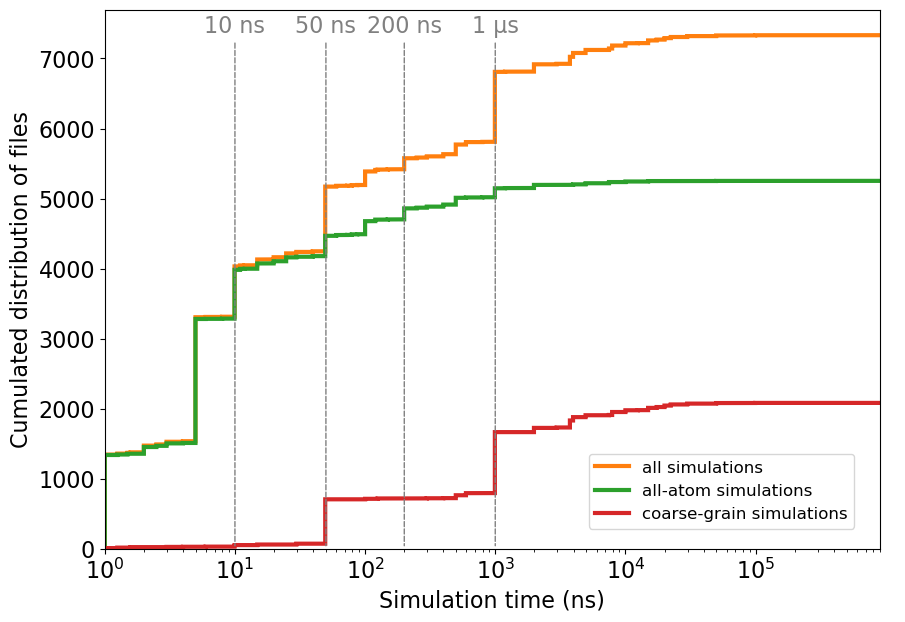

In [23]:
def plot_simulation_time_distribution(df):
    # dt is in ps
    # https://manual.gromacs.org/documentation/current/user-guide/mdp-options.html#mdp-dt
    df["time"] = df["dt"] * df["nsteps"] / 1000
    # in ns
    # 1 µs = 1 000 ns

    logbins = np.geomspace(df["time"].min()+1, df["time"].max(), 1_000)

    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    values, bins, _ = ax.hist(
        df["time"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True,
        label = "all simulations"
    )
    values, bins, _ = ax.hist(
        df[ df["dt"] <= 0.01 ]["time"], 
        bins=logbins,
        color="tab:green", linewidth=3,
        histtype="step", cumulative=True,
        label = "all-atom simulations"
    )
    values, bins, _ = ax.hist(
        df[ df["dt"] > 0.01 ]["time"], 
        bins=logbins,
        color="tab:red", linewidth=3,
        histtype="step", cumulative=True,
        label = "coarse-grain simulations"
    )
    ax.set_xlabel("Simulation time (ns)")
    ax.set_ylabel("Cumulated distribution of files")
    #ax.set_yticks(np.arange(0, 1.1, 0.2), [f"{value:.0f}" for value in np.arange(0, 1.1, 0.2)*100])
    ax.set_xscale("log")
    ax.set_xlim(1, df["time"].max() - df["time"].max() * 0.1)
    ax.annotate("10 ns", xy=(10, 0), xytext=(10, 7300), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom")
    ax.annotate("50 ns", xy=(50, 0), xytext=(50, 7300), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom")
    ax.annotate("200 ns", xy=(200, 0), xytext=(200, 7300), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom")
    ax.annotate("1 µs", xy=(1000, 0), xytext=(1000, 7300), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom")
    legend_elements = [
        Line2D([0], [0], color="tab:orange", lw=3, label="all simulations"),
        Line2D([0], [0], color="tab:green", lw=3, label="all-atom simulations"),
        Line2D([0], [0], color="tab:red", lw=3, label="coarse-grain simulations")
    ]                   
    fig.legend(handles=legend_elements, loc=(0.65, 0.15), prop={"size":12})
    filename = "fig/gromacs_simulation_time"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_simulation_time_distribution(mdp_df)

### Simulations above 50 µs

In [24]:
mdp_df.query("time > 50_000")

,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url,time
207,osf,a43z2,0.030,2.500000e+09,310.0,parrinello-rahman,v-rescale,hGBP1 dimer Martini-MD/cg_md_dimer_traj.mdp,https://osf.io/a43z2/,75000.0
370,zenodo,4451274,0.002,5.000000e+10,310.0,Berendsen,No,SARS-COV2_spike_simulations_Dform_Gform/md.mdp,https://zenodo.org/record/4451274,100000.0
2411,zenodo,7017263,0.002,5.000000e+11,300.0,Parrinello-Rahman,V-rescale,degrader-ternary-complex-prediction-paper-final/hremd/scripts/config/md.mdp,https://zenodo.org/record/7017263,1000000.0
3432,zenodo,846428,0.020,5.000000e+09,315.0,Parrinello-rahman,v-rescale,md.mdp,https://zenodo.org/record/846428,100000.0


## 4.C. Thermostat and barostat combinaison

In [25]:
# Mdp files without thermostat
print(mdp_df[ mdp_df["thermostat"].isna() ].shape[0])
mdp_df[ mdp_df["thermostat"].isna() ].head()

728


,dataset_origin,dataset_id,dt,nsteps,temperature,barostat,thermostat,filename,dataset_url,time
5,osf,2ah8r,NaN,5000.0,NaN,NaN,NaN,step6.0_minimization.mdp,https://osf.io/2ah8r/,NaN
14,osf,82n73,NaN,5000.0,NaN,NaN,NaN,Research Projects/HIV gp41 TMD - Biophysical Journal/mdp_restraint_files/step6.0_minimization.mdp,https://osf.io/82n73/,NaN
22,osf,82n73,NaN,5000.0,NaN,NaN,NaN,Research Projects/HIV GP41 MPER-TMD-CT JACS 2021/mdps/step6.0_minimization.mdp,https://osf.io/82n73/,NaN
27,osf,82n73,NaN,5000000.0,NaN,NaN,NaN,Research Projects/IAPP(20-29) + Small Molecules - ACS Neuro (2022)/Parameter files/em.mdp,https://osf.io/82n73/,NaN
29,osf,82n73,NaN,50000.0,NaN,NaN,NaN,Research Projects/IAPP(20-29) + Small Molecules - ACS Neuro (2022)/Parameter files/ions.mdp,https://osf.io/82n73/,NaN


In [26]:
# Clean barostat and thermostat names
thermostats = {
    "berendsen": "Berendsen",
    "nosehoover": "Nose-Hoover",
    "vrescale": "V-rescale",
    "no": "No temperature"
}
barostats = {
    "berendsen": "Berendsen",
    "parrinellorahman": "Parrinello-Rahman",
    "no": "No pressure"
}
def clean_thermostat_barostat(value, conversion_dict):
    if not type(value) is str:
        return None
    raw_str = value.lower().lower().replace("-", "").replace("_", "")
    return conversion_dict.get(raw_str, None)

mdp_df["thermostat"] = mdp_df["thermostat"].apply(lambda x: clean_thermostat_barostat(x, thermostats))
mdp_df["barostat"] = mdp_df["barostat"].apply(lambda x: clean_thermostat_barostat(x, barostats))
mdp_df = mdp_df.dropna(subset=["thermostat", "barostat"])

print(f"Remaining files: {mdp_df.shape[0]}")

Remaining files: 10485


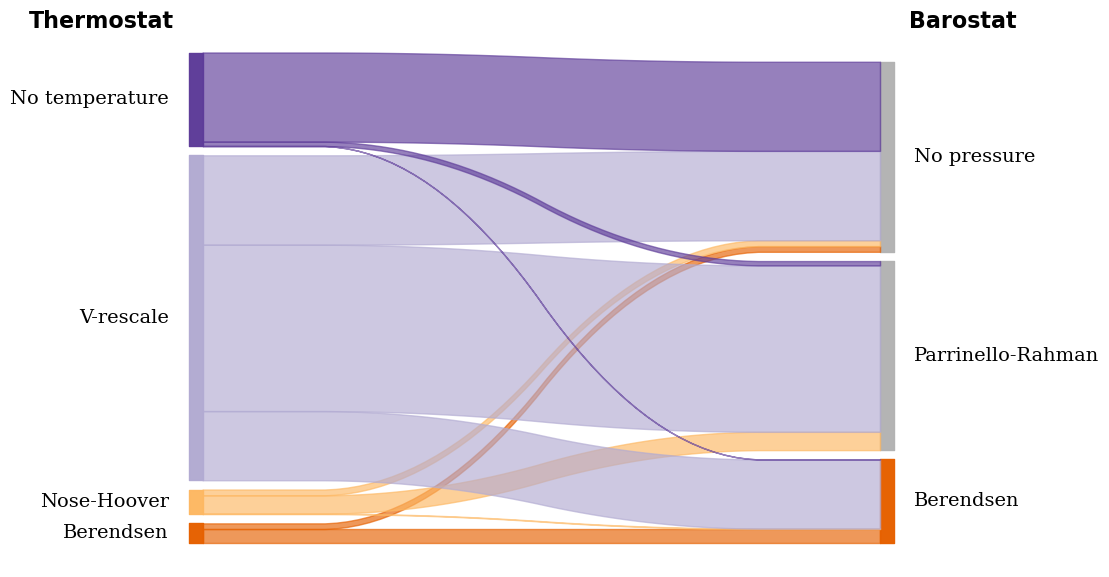

In [27]:
def plot_thermostat_barostat_sankey_graph(df):
    """Plot sankey graph with thermostats and barostats."""
    colorDict = {
        "Berendsen": "#e66101",
        "Nose-Hoover": "#fdb863",
        "V-rescale": "#b2abd2",
        "No temperature": "#5e3c99",
        "Parrinello-Rahman": "#b3b3b3",
        "No pressure": "#b3b3b3"
    }
    plt.rcParams.update({"font.family":"sans-serif"})
    fig, ax = plt.subplots(figsize=(10,7))
    ax = sankey(
        df["thermostat"], df["barostat"], aspect=10, colorDict=colorDict,
        leftLabels=["Berendsen", "Nose-Hoover", "V-rescale", "No temperature"],
        rightLabels=["Berendsen","Parrinello-Rahman","No pressure"],
        fontsize=14
    )
    plt.figtext(0.00, 0.88, "Thermostat", fontsize=16, fontweight="bold", fontfamily="sans-serif")
    plt.figtext(0.88, 0.88, "Barostat", fontsize=16, fontweight="bold", fontfamily="sans-serif")
    filename = "fig/gromacs_thermostat_barostat"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")


plot_thermostat_barostat_sankey_graph(mdp_df)

## Watermark

In [28]:
%load_ext watermark
%watermark --python --machine
print("")
# Versions for jupyterlab, imported packages and watermark itself
%watermark --packages jupyterlab,upsetplot --iversions --watermark
# Name of conda environment
%watermark --conda

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit


jupyterlab: 3.5.2
upsetplot : 0.8.0

numpy     : 1.24.1
matplotlib: 3.5.3
pandas    : 1.5.2
yaml      : 6.0

Watermark: 2.3.1

conda environment: mdda

